In [ ]:
!pip install meteostat
!pip install openmeteo-requests
!pip install requests
!pip install requests-cache retry-requests numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import json
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.models import load_model
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, multilabel_confusion_matrix,classification_report

import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from bs4 import BeautifulSoup
import requests

In [ ]:
#Membuat fungsi API
def get_json(api_url):
	response = requests.get(api_url)
	if response.status_code == 200:
		return json.loads(response.content.decode('utf-8'))
	else:
		return None

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"start_date": "2023-10-01",
	"end_date": "2023-11-01",
	"hourly": ["temperature_2m", "relative_humidity_2m"],
 "daily": "rain_sum"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s"),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

Coordinates 52.5483283996582°E 13.407821655273438°N
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                   date  temperature_2m  relative_humidity_2m
0   2023-10-01 00:00:00       13.658501             78.607887
1   2023-10-01 01:00:00       13.058500             82.015785
2   2023-10-01 02:00:00       12.958500             83.385139
3   2023-10-01 03:00:00       13.408501             81.787201
4   2023-10-01 04:00:00       13.708500             79.672935
..                  ...             ...                   ...
763 2023-11-01 19:00:00       11.208500             90.788582
764 2023-11-01 20:00:00       11.108500             89.570877
765 2023-11-01 21:00:00       10.658501             89.838051
766 2023-11-01 22:00:00       10.758500             86.864792
767 2023-11-01 23:00:00       10.408501             85.660370

[768 rows x 3 columns]


In [ ]:
hourly_dataframe= hourly_dataframe.drop(['date'], axis=1)
hourly_dataframe.head()

,temperature_2m,relative_humidity_2m
0,13.658501,78.607887
1,13.058500,82.015785
2,12.958500,83.385139
3,13.408501,81.787201
4,13.708500,79.672935


In [ ]:
# Menghitung rata-rata temperatur
mean_temp = hourly_dataframe['temperature_2m'].mean()

# Menghitung rata-rata kelembaban relatif
mean_humidity = hourly_dataframe['relative_humidity_2m'].mean()

# Menampilkan hasil
print(f"Temp: {mean_temp:.2f}")
print(f"Humidity: {mean_humidity:.3f}")

Temp: 12.07
Humidity: 82.590


In [ ]:
daily = response.Daily()
daily_rain_sum = daily.Variables(0).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s"),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["rain_sum"] = daily_rain_sum

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)

         date   rain_sum
0  2023-10-01   0.300000
1  2023-10-02   0.000000
2  2023-10-03   8.200000
3  2023-10-04   0.300000
4  2023-10-05   1.000000
5  2023-10-06   1.700000
6  2023-10-07  11.900000
7  2023-10-08   1.200000
8  2023-10-09   4.100000
9  2023-10-10   2.000000
10 2023-10-11   0.000000
11 2023-10-12   5.400000
12 2023-10-13   0.500000
13 2023-10-14   4.700000
14 2023-10-15   0.400000
15 2023-10-16   0.400000
16 2023-10-17   0.000000
17 2023-10-18   0.000000
18 2023-10-19   4.900000
19 2023-10-20   7.100000
20 2023-10-21   0.000000
21 2023-10-22   1.400000
22 2023-10-23   0.300000
23 2023-10-24   9.000001
24 2023-10-25   0.100000
25 2023-10-26   6.500000
26 2023-10-27   7.400001
27 2023-10-28   4.800000
28 2023-10-29   5.100000
29 2023-10-30   0.000000
30 2023-10-31   3.700000
31 2023-11-01   0.300000


In [ ]:
daily_dataframe= daily_dataframe.drop(['date'], axis=1)
daily_dataframe.head()

,rain_sum
0,0.3
1,0.0
2,8.2
3,0.3
4,1.0


In [ ]:
# Menghitung rata-rata temperatur
mean_rain = daily_dataframe['rain_sum'].mean()

# Menampilkan hasil
print(f"Rain: {mean_rain:.2f}")

Rain: 2.90


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_crop = pd.read_csv('/content/drive/My Drive/content/Fixed_Crop-Recommendation.csv')
df_crop.shape

(2200, 8)

In [ ]:
df_crop = df_crop.drop(['N', 'P', 'K', 'ph'], axis=1)
df_crop.head()

,temperature,humidity,rainfall,label
0,20.9,82.0,202.9,rice
1,21.8,80.3,226.7,rice
2,23.0,82.3,264.0,rice
3,26.5,80.2,242.9,rice
4,20.1,81.6,262.7,rice


<ipython-input-14-ae765d78eaa0>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_crop.corr(), annot=True)


<Axes: >

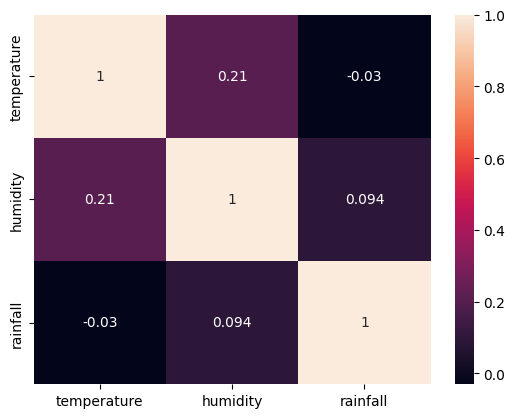

In [ ]:
sns.heatmap(df_crop.corr(), annot=True)

In [ ]:
X = df_crop.drop('label', axis=1)
y = df_crop['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

In [ ]:
clf=RandomForestClassifier(n_estimators=60,max_depth=5,bootstrap=False,random_state=0)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=5, n_estimators=60,
                       random_state=0)

In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
print("Accuracy:", accuracy_score(y_pred, y_test))

Accuracy: 0.8136363636363636


In [ ]:
print(cross_val_score(clf,X,y,cv=10).mean())

0.8295454545454545


In [ ]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df_crop['label_encoded']= label_encoder.fit_transform(df_crop['label'])

In [ ]:
X=df_crop.drop(['label','label_encoded'],axis=1)
y=df_crop['label_encoded']
print(len(y.unique()))

22


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=5)

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
ann=Sequential()
ann.add(keras.layers.Dense(128,input_shape=(3,),activation='relu'))
ann.add(keras.layers.Dense(64,input_shape=(3,),activation='relu'))
ann.add(keras.layers.Dense(28,input_shape=(3,),activation='relu'))
ann.add(keras.layers.Dense(22,input_shape=(3,),activation='softmax'))

ann.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=['accuracy'])

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.90:  # Ganti dengan akurasi yang diinginkan
            self.model.stop_training = True

# Callback untuk menghentikan pelatihan jika akurasi >= 0.95
custom_callback = CustomCallback()

ann.fit(x=X_train,y=y_train,batch_size=50,epochs = 300)

Epoch 1/300
36/36 [==============================] - 2s 3ms/step - loss: 2.9669 - accuracy: 0.0864
Epoch 2/300
36/36 [==============================] - 0s 3ms/step - loss: 2.5434 - accuracy: 0.1937
Epoch 3/300
36/36 [==============================] - 0s 3ms/step - loss: 1.8630 - accuracy: 0.3716
Epoch 4/300
36/36 [==============================] - 0s 3ms/step - loss: 1.3286 - accuracy: 0.5460
Epoch 5/300
36/36 [==============================] - 0s 3ms/step - loss: 1.0524 - accuracy: 0.6506
Epoch 6/300
36/36 [==============================] - 0s 2ms/step - loss: 0.9046 - accuracy: 0.6915
Epoch 7/300
36/36 [==============================] - 0s 3ms/step - loss: 0.8203 - accuracy: 0.7074
Epoch 8/300
36/36 [==============================] - 0s 2ms/step - loss: 0.7477 - accuracy: 0.7369
Epoch 9/300
36/36 [==============================] - 0s 2ms/step - loss: 0.6745 - accuracy: 0.7568
Epoch 10/300
36/36 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.7892
Epoch 11/

In [ ]:
preds=ann.predict(X_test)

14/14 [==============================] - 0s 2ms/step


In [ ]:
eval=ann.evaluate(X_test,y_test)
print(eval)

14/14 [==============================] - 0s 2ms/step - loss: 0.2423 - accuracy: 0.9182
[0.24232856929302216, 0.918181836605072]


In [ ]:
y_pred=[]
for x in preds:
    y_pred.append(np.argmax(x))
print(y_pred)

[7, 15, 4, 3, 21, 17, 17, 19, 18, 0, 4, 17, 19, 11, 2, 3, 6, 15, 13, 19, 15, 3, 5, 19, 2, 8, 19, 21, 20, 19, 0, 13, 8, 8, 1, 13, 4, 14, 9, 2, 12, 3, 11, 17, 1, 11, 4, 19, 19, 11, 5, 13, 18, 16, 12, 19, 15, 18, 14, 13, 6, 2, 3, 6, 14, 14, 3, 4, 4, 1, 8, 11, 19, 21, 1, 9, 17, 0, 7, 3, 3, 1, 0, 11, 19, 15, 1, 3, 20, 17, 18, 16, 12, 5, 15, 0, 18, 21, 5, 7, 20, 4, 11, 11, 13, 2, 16, 18, 18, 11, 18, 12, 12, 19, 10, 2, 18, 15, 19, 10, 4, 15, 10, 11, 12, 5, 6, 2, 5, 18, 2, 11, 4, 5, 16, 4, 14, 2, 11, 0, 16, 11, 0, 17, 15, 19, 2, 19, 10, 14, 7, 1, 10, 20, 18, 5, 14, 2, 21, 8, 10, 0, 20, 14, 14, 0, 8, 9, 18, 18, 15, 7, 11, 12, 9, 3, 21, 19, 10, 10, 21, 7, 17, 5, 0, 4, 21, 16, 7, 8, 5, 3, 0, 19, 17, 7, 11, 21, 4, 6, 17, 11, 2, 6, 20, 13, 5, 4, 11, 14, 2, 10, 3, 6, 15, 21, 11, 11, 2, 15, 17, 0, 16, 5, 0, 7, 20, 21, 17, 16, 21, 9, 21, 20, 6, 14, 2, 15, 2, 18, 13, 19, 0, 10, 5, 8, 15, 9, 21, 10, 21, 0, 12, 18, 4, 7, 12, 9, 10, 4, 19, 5, 0, 7, 15, 2, 15, 20, 13, 20, 2, 2, 17, 8, 5, 5, 12, 1, 5, 13, 1

(440,) (440,)


<Axes: xlabel='label_encoded'>

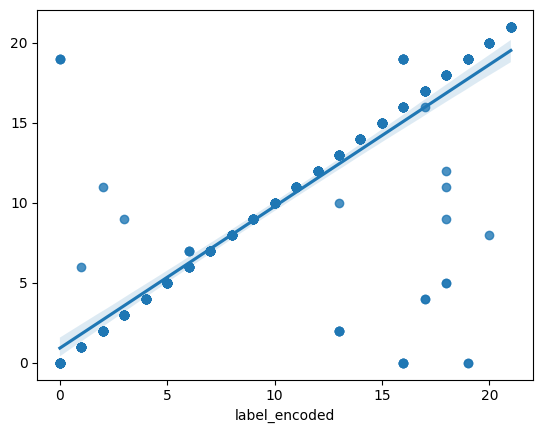

In [ ]:
y_pred=np.array(y_pred)
print(y_pred.shape,y_test.shape)
sns.regplot(x=y_test,y=y_pred,label="Predicted")

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix,classification_report
print(y_pred.shape,y_test.shape)
multi_confuse_matrix=multilabel_confusion_matrix(y_test,y_pred)
accur=[]
for x in multi_confuse_matrix:
    accur.append((x[0][0])/(x[0][0]+x[1][1]+x[0][1]+x[1][0]))
print((sum(accur)/22)*100)

(440,) (440,)
95.08264462809916


In [ ]:
sensi=[]
for x in multi_confuse_matrix:
    sensi.append((x[0][0])/(x[0][0]+x[1][0]))
print("Sensitivity is ",(sum(sensi)/22)*100)
speci=[]
for x in multi_confuse_matrix:
    speci.append((x[1][1])/(x[1][1]+x[0][1]))
print("Specificity is ",(sum(speci)/22)*100)

Sensitivity is  99.6131796030264
Specificity is  92.66873935779645


In [ ]:
labels=[f"{x}" for x in range(1,23)]
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

           1       0.78      0.88      0.82        24
           2       1.00      0.93      0.97        15
           3       0.84      0.95      0.89        22
           4       1.00      0.95      0.97        19
           5       0.91      1.00      0.95        20
           6       0.93      1.00      0.96        25
           7       0.91      0.77      0.83        13
           8       0.85      1.00      0.92        17
           9       0.94      1.00      0.97        15
          10       0.89      1.00      0.94        16
          11       0.95      1.00      0.97        18
          12       0.93      1.00      0.96        27
          13       0.95      1.00      0.97        18
          14       1.00      0.77      0.87        22
          15       1.00      1.00      1.00        19
          16       1.00      1.00      1.00        24
          17       0.92      0.52      0.67        23
          18       1.00    

In [ ]:
# Contoh input suhu, kelembaban, dan curah hujan
temperature = mean_temp  # Ganti dengan nilai suhu yang diinginkan
humidity = mean_humidity  # Ganti dengan nilai kelembaban yang diinginkan
rainfall = mean_rain  # Ganti dengan nilai curah hujan yang diinginkan

# Menyiapkan input untuk prediksi
input_data = np.array([[temperature, humidity, rainfall]])

# Normalisasi data input (jika Anda telah melakukan normalisasi saat pelatihan)
input_data = sc.transform(input_data)  # sc adalah objek StandardScaler yang digunakan saat pelatihan

# Melakukan prediksi dengan model
prediction = ann.predict(input_data)

# Mendapatkan indeks dari label dengan probabilitas tertinggi
predicted_indices = prediction[0].argsort()[-3:][::-1]

# Mendapatkan label kelas (nama tanaman) berdasarkan indeks hasil prediksi
predicted_labels = label_encoder.inverse_transform(predicted_indices)

# Menampilkan 3 hasil prediksi terbaik
print("Hasil prediksi terbaik:")
for i, label in enumerate(predicted_labels, start=1):
    print(f"Ranking-{i}: {label}")


1/1 [==============================] - 0s 21ms/step
Hasil prediksi terbaik:
Ranking-1: lentil
Ranking-2: watermelon
Ranking-3: kidneybeans


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
ann.save('model.h5')

model = load_model('model.h5')

model_json = model.to_json()

with open ('model.json', 'w') as file:
  file.write(model_json)